## K-Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1. Read and visualise the data

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [114]:
# read the dataset

retail_df = pd.read_csv("Online+Retail.csv",sep=",",encoding="ISO-8859-1",header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [115]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 22.7+ MB


# 2. Clean the data

In [116]:
#missing values 

round(100*retail_df.isnull().sum()/len(retail_df),2)
#len(retail_df)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [117]:
# drop all the row having missing values

retail_df.shape

(541909, 8)

In [118]:
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [119]:
# new column : Amount
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


# 3. Prepare the data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [120]:
# monetary
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()
grouped_df.head()

CustomerID
12346.0       0.00
12347.0    4310.00
12348.0    1797.24
12349.0    1757.55
12350.0     334.40
Name: amount, dtype: float64

In [121]:
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [122]:
# frequency

frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency.head()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [123]:
frequency.columns = ['CustomerID','frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [124]:
# merged the two dfs

grouped_df = pd.merge(grouped_df,frequency,on='CustomerID', how = 'inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [125]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [126]:
# recency 
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'],format='%d-%m-%Y %H:%M')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [127]:
# compute the max date 
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [128]:
retail_df['diff'] =max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [133]:
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [145]:
#merge
grouped_df = pd.merge(grouped_df,last_purchase,on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
#grouped_df.drop(["diff_x", "diff_y","diff_x", "diff_y","diff_x", "diff_y","diff_x", "diff_y","diff"], axis = 1, inplace = True)
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [146]:
# number of days only

grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()


,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


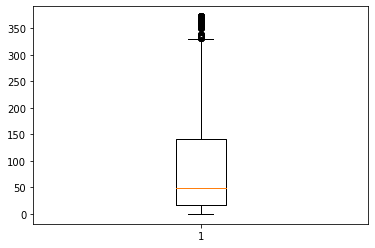

In [147]:
# 1 . outlier treatment (we will check this one first)
# 2 . rescalling 

plt.boxplot(grouped_df['recency'])
plt.show()

In [148]:
# two types of outliers:
# - statistical
# - domain specific

In [152]:
# removing (statistical) outliers

rfm_df = grouped_df[['amount', 'frequency', 'recency']]
rfm_df.head()

#instiate
scaler = StandardScaler()

# fit transform
rfm_df_scaler = scaler.fit_transform(rfm_df)
rfm_df_scaler.shape

(4372, 3)

In [153]:
rfm_df_scaler = pd.DataFrame(rfm_df_scaler)
rfm_df_scaler

,0,1,2
0,-0.231001,-0.391720,2.322023
1,0.293432,0.382657,-0.893733
2,-0.012316,-0.266959,-0.169196
3,-0.017146,-0.086271,-0.725005
4,-0.190312,-0.327188,2.163220
...,...,...,...
4367,-0.209026,-0.357303,1.845615
4368,-0.221167,-0.370209,0.882873
4369,-0.209513,-0.344397,-0.834182
4370,0.023900,2.852058,-0.873883


In [154]:
rfm_df_scaler.columns = ['amount', 'frequency', 'recency']
rfm_df_scaler.head()

,amount,frequency,recency
0,-0.231001,-0.391720,2.322023
1,0.293432,0.382657,-0.893733
2,-0.012316,-0.266959,-0.169196
3,-0.017146,-0.086271,-0.725005
4,-0.190312,-0.327188,2.163220


# 4. Modelling

In [162]:
#k- mean with some arbitrary k
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(rfm_df_scaler)


KMeans(max_iter=50, n_clusters=4)

In [164]:
kmeans.labels_

array([2, 0, 0, ..., 0, 0, 0])

In [166]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random', ndarray, callable}, default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` observations (rows) at random from data
 |      for 

In [168]:
range_n_clusters = [2,3,4,5,6,7,8]
ssd = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(rfm_df_scaler)
    
    ssd.append(kmeans.inertia_)
print(ssd)

[8988.644490981602, 5408.404670803712, 4013.8552489160033, 2938.144318501159, 2323.1586627464612, 1861.989610853026, 1616.8318457694102]


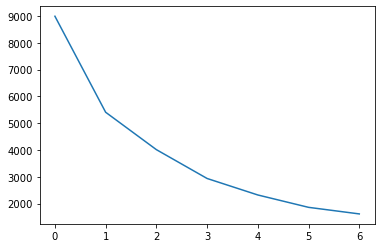

In [169]:
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [170]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(rfm_df_scaler)
    
    cluster_labels= kmeans.labels_
    
    #silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaler,cluster_labels)
    print("For n_clusters={0},silhouette score is {1}".format(num_clusters,silhouette_avg))


For n_clusters=2,silhouette score is 0.9344641162235822
For n_clusters=3,silhouette score is 0.6003883114752382
For n_clusters=4,silhouette score is 0.5981422039499412
For n_clusters=5,silhouette score is 0.6160117259955692
For n_clusters=6,silhouette score is 0.5860954318128131
For n_clusters=7,silhouette score is 0.5237772274142556
For n_clusters=8,silhouette score is 0.4682302837546287


In [171]:
# final model with K=3

kmeans = KMeans(n_clusters=3,max_iter=50)
kmeans.fit(rfm_df_scaler)

KMeans(max_iter=50, n_clusters=3)

In [172]:
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [173]:
# assigning the label
grouped_df['cluster'] = kmeans
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster
0,12346.0,0.00,2,325,"KMeans(max_iter=50, n_clusters=3)"
1,12347.0,4310.00,182,1,"KMeans(max_iter=50, n_clusters=3)"
2,12348.0,1797.24,31,74,"KMeans(max_iter=50, n_clusters=3)"
3,12349.0,1757.55,73,18,"KMeans(max_iter=50, n_clusters=3)"
4,12350.0,334.40,17,309,"KMeans(max_iter=50, n_clusters=3)"
